In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import gensim
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Set the display options to ensure all columns are shown
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)        # No max width
pd.set_option('display.max_colwidth', -1)  # For pandas versions >= 1.0

<ipython-input-2-a92e0564eb27>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # For pandas versions >= 1.0


In [ ]:
# Connecting the Python Code with the google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# IMPORTANT FUNCTIONS

# Preprocessing Function

def preprocess(text):
    if pd.isnull(text):
        return ''
    tokens = nltk.word_tokenize(text)
    filtered = [lemmatizer.lemmatize(word.lower()) for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(filtered)

# Bootstrapping Function for computing confidence intervals of F1-score

def bootstrap_f1_macro(clf, X, y, n_iterations=1000, ci=0.95):
    scores = []
    for _ in range(n_iterations):
        # Sampling with replacement
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_resampled = X[indices]
        y_resampled = y[indices]

        # Predict and compute F1 macro score
        y_pred = clf.predict(X_resampled)
        score = f1_score(y_resampled, y_pred, average='macro')
        scores.append(score)

    # Sort scores and get percentiles for confidence interval
    lower_bound = (1.0 - ci) / 2.0
    upper_bound = 1.0 - lower_bound
    lower, upper = np.percentile(scores, [lower_bound*100, upper_bound*100])

    return lower, upper


# Functions for word cluster feature

def fit_word_clusters(df):
    # Tokenize and train Word2Vec
    sentences = df['text'].apply(word_tokenize).tolist()
    model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

    # Get word vectors for all words in vocabulary
    word_vectors = {word: model.wv[word] for word in model.wv.index_to_key}

    # Cluster words using K-means
    num_clusters = 10
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(list(word_vectors.values()))

    return model, kmeans

def transform_word_clusters(df, model, kmeans):
    word_vectors = {word: model.wv[word] for word in model.wv.index_to_key}
    num_clusters = kmeans.n_clusters

    # Get the cluster assignment for each word
    word_cluster_assignment = {word: kmeans.predict([vector])[0] for word, vector in word_vectors.items()}

    # Define the transform function
    def get_cluster_representation(text):
        tokens = word_tokenize(text)
        clusters = [word_cluster_assignment.get(token, -1) for token in tokens if token in word_cluster_assignment]
        representation = np.bincount(clusters, minlength=num_clusters)
        return representation[:10]

    # Transform the dataframe
    cluster_features = df['text'].apply(get_cluster_representation)
    array_representation = np.array(cluster_features.tolist())

    return array_representation

In [ ]:
## HYPERPARAMETER TUNING & PERFORMANCE COMPARISON (On training and Dev Data)

# Training Data Upload
df_train = pd.read_csv("/content/drive/MyDrive/Emory/BMI NLP/Breast Cancer Data/Classification_ data/train.csv")
df_train = df_train.dropna(subset=['text'])

# Testing Data Upload
df_test = pd.read_csv("/content/drive/MyDrive/Emory/BMI NLP/Breast Cancer Data/Classification_ data/dev_.csv")
df_test = df_test.dropna(subset = ["text"])

# Fall Description Sentiment (Computed before Pre-processing)
sia = SentimentIntensityAnalyzer()
df_train['sentiment'] = df_train['text'].apply(lambda x: (sia.polarity_scores(x)['compound'] + 1) / 2)
df_test['sentiment'] = df_test['text'].apply(lambda x: (sia.polarity_scores(x)['compound'] + 1) / 2)

# Pre-processing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
df_train['text'] = df_train['text'].apply(preprocess)
df_test["text"] = df_test["text"].apply(preprocess)

# Preprocessed word length of fall description
df_train['processed_text_length'] = df_train['text'].apply(lambda x:len(word_tokenize(x)))
df_test['processed_text_length'] = df_test['text'].apply(lambda x:len(word_tokenize(x)))

# Count of unique words (indicating vocabulary diversity)
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(word_tokenize(x))))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(word_tokenize(x))))

# Hyper parameter Tuning
df_train = df_train.dropna().reset_index(drop = True)
df_test = df_test.dropna().reset_index(drop = True)
train_df, test_df = df_train.copy(), df_test.copy()

# TF-IDF Vector
vectorizer = TfidfVectorizer(ngram_range=(1, 2),stop_words = "english", max_features = 1000)
X_train_tfidf = vectorizer.fit_transform(train_df['text'])
X_test_tfidf = vectorizer.transform(test_df['text'])

# Word Cluster Represenattion
model, kmeans = fit_word_clusters(train_df)  # Only on training data
train_clusters = transform_word_clusters(train_df, model, kmeans)
test_clusters = transform_word_clusters(test_df, model, kmeans)

# In training the models, variables from columns_to_use, word_cluster feature and TF-IDF vectors are used (combined using np.hstack)
columns_to_use = ['unique_word_count','processed_text_length','sentiment']

# Combining Vectors & Features
X_train = np.hstack((X_train_tfidf.toarray(), train_df[columns_to_use].values))
X_test = np.hstack((X_test_tfidf.toarray(), test_df[columns_to_use].values))

# Initializing Final Features
y_train = train_df['Class']
y_test = test_df["Class"]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:


# Setting up classifiers and parameters for GridSearch
models = {
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(solver='liblinear') ,
    'Random Forest': RandomForestClassifier(),
    #'SVM': SVC(),
    #'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
}

# Range of paramaters for Hyperparameter tuning
params = {
    'Naive Bayes': {
        'alpha': [0.01, 0.1, 1, 10, 100]
    },
    'Decision Tree': {
        'max_depth': [None, 3, 5, 10, 15, 20],

    },
    'Random Forest': {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 5, 10],

    },
    'SVM': {
        'C': [ 0.01, 0.1, 1, 10],
        'kernel': ['linear', 'rbf','poly','sigmoid'],
    },
    'XGBoost': {
        'n_estimators': [10,50,100, 200],
        'max_depth': [None, 3, 5, 10],
    },

    'Logistic Regression': {'C': [ 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
    }

# Model Performance Print
for model_name, model in models.items():

  try:
    grid_search = GridSearchCV(model, params[model_name], cv=5)
    grid_search.fit(X_train, y_train)
    models[model_name].set_params(**grid_search.best_params_)
    predictions = grid_search.predict(X_test)
    print(model_name)
    print("Best Parameters:", grid_search.best_params_)
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Micro F1:", f1_score(y_test, predictions, average='micro'))
    print("Macro F1:", f1_score(y_test, predictions, average='macro'))
    print("------------")

  except :
    print(f"Error with model {model_name}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Naive Bayes
Best Parameters: {'alpha': 0.1}
Accuracy: 0.7483443708609272
Micro F1: 0.7483443708609272
Macro F1: 0.44057716681290826
------------
Decision Tree
Best Parameters: {'max_depth': 10}
Accuracy: 0.7814569536423841
Micro F1: 0.7814569536423841
Macro F1: 0.6478942905596382
------------
Logistic Regression
Best Parameters: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.8013245033112583
Micro F1: 0.8013245033112583
Macro F1: 0.7449324324324325
------------
Random Forest
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Accuracy: 0.7582781456953642
Micro F1: 0.7582781456953643
Macro F1: 0.5002606823076051
------------


In [ ]:
# Evaluate trained classifiers with optimal hyperparameters (On Test Data)

# Test Data Upload
df1 = pd.read_csv("/content/drive/MyDrive/Emory/BMI NLP/Breast Cancer Data/Classification_ data/test_data.csv")
df1 = df1.dropna(subset=['text'])

# Fall Description Sentiment (Computed before Pre-processing)
sia = SentimentIntensityAnalyzer()
df1['sentiment'] = df1['text'].apply(lambda x: (sia.polarity_scores(x)['compound'] + 1) / 2)

# Pre-processing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
df1['processed_text'] = df1['text'].apply(preprocess)

# Preprocessed word length
df1['processed_text_length'] = df1['processed_text'].apply(lambda x:len(word_tokenize(x)))

# Count of unique words (indicating vocabulary diversity)
df1['unique_word_count'] = df1['processed_text'].apply(lambda x: len(set(word_tokenize(x))))

df1 = df1.dropna().reset_index(drop = True)
test_df = df1.copy()

# TF-IDF Vector
X_test_tfidf = vectorizer.transform(test_df['processed_text'])

# Word Cluster Represenattion
#test_clusters = transform_word_clusters(test_df, model, kmeans)
columns_to_use = ['unique_word_count','processed_text_length','sentiment']

# Combining Vectors & Features
X_test = np.hstack((X_test_tfidf.toarray(),test_df[columns_to_use].values))

# Initializing Final Features
#y_test = test_df["Class"]

# Using Optimal tuned Hyperparameters
classifiers = {
    #"Naive Bayes": MultinomialNB(alpha=0.1),
    #"Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=10),
    #"Logistic Regression": LogisticRegression(C=10, penalty='l2'),
    "Random Forest": RandomForestClassifier(max_depth=None, n_estimators=50),
    #"XGBoost": XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, use_label_encoder=False, eval_metric="logloss"),
    #"SVM": SVC(C=0.1, kernel='linear', probability=True)
}

# Output performance of the classifiers on test data from  "fallreports_2023-9-21_test.csv"
for clf_name, clf in classifiers.items() :

  try :
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    df1["predicted_label"] = predictions

  except :
    print(f"Error with model {model_name}")

In [ ]:
df2 = df1[df1.predicted_label == 1].copy()
df2.to_csv("self_reported.csv")

In [ ]:
# Evaluate trained classifiers with optimal hyperparameters (On Test Data)

# Test Data Upload
df1 = pd.read_csv("/content/drive/MyDrive/Emory/BMI NLP/Breast Cancer Data/Classification_ data/test.csv")
df1 = df1.dropna(subset=['text'])

# Fall Description Sentiment (Computed before Pre-processing)
sia = SentimentIntensityAnalyzer()
df1['sentiment'] = df1['text'].apply(lambda x: (sia.polarity_scores(x)['compound'] + 1) / 2)

# Pre-processing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
df1['text'] = df1['text'].apply(preprocess)

# Preprocessed word length of fall description
df1['processed_text_length'] = df1['text'].apply(lambda x:len(word_tokenize(x)))

# Count of unique words (indicating vocabulary diversity)
df1['unique_word_count'] = df1['text'].apply(lambda x: len(set(word_tokenize(x))))

df1 = df1.dropna().reset_index(drop = True)
test_df = df1

# TF-IDF Vector
X_test_tfidf = vectorizer.transform(test_df['text'])

# Word Cluster Represenattion
test_clusters = transform_word_clusters(test_df, model, kmeans)
columns_to_use = ['unique_word_count','processed_text_length','sentiment']

# Combining Vectors & Features
X_test = np.hstack((X_test_tfidf.toarray(),test_df[columns_to_use].values))

# Initializing Final Features
y_test = test_df["Class"]

# Using Optimal tuned Hyperparameters
classifiers = {
    "Naive Bayes": MultinomialNB(alpha=0.1),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=10),
    "Logistic Regression": LogisticRegression(C=10, penalty='l2'),
    "Random Forest": RandomForestClassifier(max_depth=None, n_estimators=50),
    #"XGBoost": XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, use_label_encoder=False, eval_metric="logloss"),
    #"SVM": SVC(C=0.1, kernel='linear', probability=True)
}

# Output performance of the classifiers on test data from  "fallreports_2023-9-21_test.csv"
for clf_name, clf in classifiers.items() :

  try :
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print("-------------------------------------------------------------")
    print(f"Performance of {clf_name} on Test.csv")
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Micro F1:", f1_score(y_test, predictions, average='micro'))
    print("Macro F1:", f1_score(y_test, predictions, average='macro'))
    #lower, upper = bootstrap_f1_macro(clf, X_test, y_test)
   #print(f"95% confidence interval of F1 macro score: ({lower:.4f}, {upper:.4f})")

  except :
    print(f"Error with model {model_name}")


-------------------------------------------------------------
Performance of Naive Bayes on Test.csv
Accuracy: 0.7649501661129569
Micro F1: 0.764950166112957
Macro F1: 0.5697257843527236
-------------------------------------------------------------
Performance of Decision Tree on Test.csv
Accuracy: 0.7425249169435216
Micro F1: 0.7425249169435216
Macro F1: 0.5902334057923281


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-------------------------------------------------------------
Performance of Logistic Regression on Test.csv
Accuracy: 0.7857142857142857
Micro F1: 0.7857142857142857
Macro F1: 0.6879136777382603
-------------------------------------------------------------
Performance of Random Forest on Test.csv
Accuracy: 0.7732558139534884
Micro F1: 0.7732558139534884
Macro F1: 0.5882946063652431


In [ ]:
# Ensemble Classifier (On Test Data)

from sklearn.ensemble import VotingClassifier

# Initialize the individual models with their best parameters
naive_bayes = MultinomialNB(alpha=0.1)
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=10)
logistic_regression = LogisticRegression(C=10, penalty='l2')
random_forest = RandomForestClassifier(max_depth=None, n_estimators=50)
#xgboost = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, use_label_encoder=False, eval_metric="logloss")
#svm = SVC(C=0.1, kernel='linear', probability=True)

# Create an ensemble of the models using soft voting
ensemble = VotingClassifier(estimators=[
    ('naive_bayes', naive_bayes),
    ('decision_tree', decision_tree),
    ('logistic_regression', logistic_regression),
    ('random_forest', random_forest)
    #('xgboost', xgboost),
    #('svm', svm)
], voting='soft')

# Train and evaluate the ensemble
ensemble.fit(X_train, y_train)
ensemble_predictions = ensemble.predict(X_test) # Test data is from

ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_micro_f1 = f1_score(y_test, ensemble_predictions, average='micro')
ensemble_macro_f1 = f1_score(y_test, ensemble_predictions, average='macro')

print("\nEnsemble Classifier:")
print("Accuracy:", ensemble_accuracy)
print("Micro F1:", ensemble_micro_f1)
print("Macro F1:", ensemble_macro_f1)
#lower, upper = bootstrap_f1_macro(clf, X_test, y_test)
#print(f"95% confidence interval of F1 macro score: ({lower:.4f}, {upper:.4f})")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Ensemble Classifier:
Accuracy: 0.7632890365448505
Micro F1: 0.7632890365448505
Macro F1: 0.5155408410337501


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

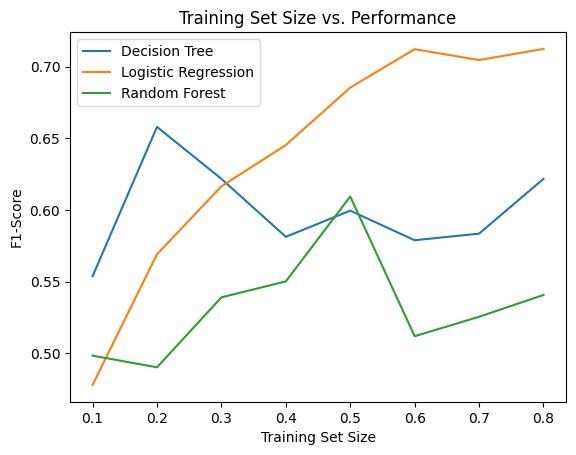

In [ ]:
# Train Size Performance Variation Study (On Training Data)


# Define classifiers and their respective hyperparameters
classifiers = {
    #"Naive Bayes": MultinomialNB(alpha=0.1),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=10),
    "Logistic Regression": LogisticRegression(C=10, penalty='l2'),
    "Random Forest": RandomForestClassifier(max_depth=None, n_estimators=50)
    #"XGBoost": XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, use_label_encoder=False, eval_metric="logloss"),
    #"SVM": SVC(C=0.1, kernel='linear', probability=True)
}

# Training set size vs. performance
sizes = [i/10 for i in range(1,9)]

for clf_name, clf in classifiers.items():
    performance = []
    for size in sizes:

      # Training Data Upload
      df = pd.read_csv("/content/drive/MyDrive/Emory/BMI NLP/Breast Cancer Data/Classification_ data/train.csv")
      df_train, temp = train_test_split(df, train_size= size, random_state= 20)

      # Testing Data Upload
      df_test = pd.read_csv("/content/drive/MyDrive/Emory/BMI NLP/Breast Cancer Data/Classification_ data/dev_.csv")
      df_test = df_test.dropna(subset = ["text"])

      # Fall Description Sentiment (Computed before Pre-processing)
      sia = SentimentIntensityAnalyzer()
      df_train['sentiment'] = df_train['text'].apply(lambda x: (sia.polarity_scores(x)['compound'] + 1) / 2)
      df_test['sentiment'] = df_test['text'].apply(lambda x: (sia.polarity_scores(x)['compound'] + 1) / 2)

      # Pre-processing
      lemmatizer = WordNetLemmatizer()
      stop_words = set(stopwords.words('english'))
      df_train['text'] = df_train['text'].apply(preprocess)
      df_test["text"] = df_test["text"].apply(preprocess)

      # Preprocessed word length of fall description
      df_train['processed_text_length'] = df_train['text'].apply(lambda x:len(word_tokenize(x)))
      df_test['processed_text_length'] = df_test['text'].apply(lambda x:len(word_tokenize(x)))

      # Count of unique words (indicating vocabulary diversity)
      df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(word_tokenize(x))))
      df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(word_tokenize(x))))

      # Hyper parameter Tuning
      df_train = df_train.dropna().reset_index(drop = True)
      df_test = df_test.dropna().reset_index(drop = True)
      train_df, test_df = df_train.copy(), df_test.copy()

      # TF-IDF Vector
      vectorizer = TfidfVectorizer(ngram_range=(1, 3))
      X_train_tfidf = vectorizer.fit_transform(train_df['text'])
      X_test_tfidf = vectorizer.transform(test_df['text'])

      # Word Cluster Represenattion
      model, kmeans = fit_word_clusters(train_df)  # Only on training data
      train_clusters = transform_word_clusters(train_df, model, kmeans)
      test_clusters = transform_word_clusters(test_df, model, kmeans)

      # In training the models, variables from columns_to_use, word_cluster feature and TF-IDF vectors are used (combined using np.hstack)
      columns_to_use = ['unique_word_count','processed_text_length','sentiment']

      # Combining Vectors & Features
      X_train = np.hstack((X_train_tfidf.toarray(), train_df[columns_to_use].values))
      X_test = np.hstack((X_test_tfidf.toarray(), test_df[columns_to_use].values))

      # Initializing Final Features
      y_train = train_df['Class']
      y_test = test_df["Class"]

      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)

      performance.append(f1_score(y_test, y_pred, average = 'macro'))

    plt.plot(sizes, performance, label=clf_name)

plt.xlabel("Training Set Size")
plt.ylabel("F1-Score")
plt.title("Training Set Size vs. Performance")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load pre-trained Word2Vec embeddings
word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Emory/BMI NLP/Breast Cancer Data/GoogleNews-vectors-negative300.bin', binary=True)

# Define the list of uncertainty words
# uncertainty_words = [
#     "uncertain", "doubtful", "ambiguous", "hesitant", "perplexed", "confused",
#     "questionable", "unsure", "indecisive", "bewildered", "vague", "puzzled",
#     "skeptical", "inconclusive", "wavering", "distrustful", "baffled", "ambivalent",
#     "hazy", "tentative"]

# fear_words = ["terrified", "scared", "nervous", "suspicion","uncertain","hesitant","perplexed" ,"clueless"
#               , "worried", "alarmed", "anxiety", "unsure","puzzled", "skeptical", "baffled",
#               "doubtful", "unaware" , "awkward", "paranoid", "myth", "confused", "embarrassed"]

fear_words_1 = ["scared", "nervous","worried", "suspicion","uncertain","reluctant" ,"confused", "doubtful",
               "unsure","skeptical", "awkward", "insurance", "soy", "covid", "black", "bra","concerned"]

# Function to find similar words in a text
def find_similar_words(text, word_vectors, uncertainty_words, threshold=0.5):
    similar_words = []
    unc_words = []
    for word in text.lower().split():
        if word in word_vectors:
            word_embedding = word_vectors[word]
            for unc_word in uncertainty_words:
                if unc_word in word_vectors:
                    unc_embedding = word_vectors[unc_word]
                    similarity = cosine_similarity([word_embedding], [unc_embedding])[0][0]
                    if similarity > threshold:
                        similar_words.append(word)
                        similar_words.append(unc_word)
                        break
    return similar_words

# Load your dataset
#df = pd.read_csv('/content/self_reported.csv')
df = pd.read_csv("/content/drive/MyDrive/Emory/BMI NLP/Breast Cancer Data/Classification_ data/test_data_2.csv")

# Apply the function to each text
df['similar_uncertainty_words'] = df['text'].apply(lambda x: find_similar_words(x, word_vectors, fear_words_1))

df.to_csv('./output.csv', encoding='utf-8', index=False)
